In [2]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# 2. Load Data (replace with your actual dataset)
df = pd.read_csv('/Users/shivendra/Data Science/customer_booking.csv',encoding='latin1')  # Replace with actual filename

# 3. Basic Cleaning (update based on your dataset)
df.dropna(inplace=True)  # Drop rows with missing values (or handle appropriately)


In [4]:

# 4. Feature Engineering (example — update according to your features)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 5. Separate Features and Target
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

In [5]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [6]:

# 8. Random Forest Hyperparameter Tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rfc = RandomForestClassifier(random_state=42)
rfc_random = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    verbose=3,
    n_jobs=-1,
    scoring='roc_auc',
    random_state=42
)
rfc_random.fit(X_train_sm, y_train_sm)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [7]:

# 9. Evaluate Tuned Model
best_model = rfc_random.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, y_pred_prob))

Tuned Model Accuracy: 0.8174

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      8504
           1       0.39      0.38      0.38      1496

    accuracy                           0.82     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.82      0.82      0.82     10000


ROC-AUC: 0.7751173480488578


In [8]:

# 10. Feature Importances
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Important Features:")
print(importances.head(10))


Top 10 Important Features:
                      feature  importance
865   booking_origin_Malaysia    0.164987
7             flight_duration    0.070209
2              length_of_stay    0.038424
818  booking_origin_Australia    0.036568
851  booking_origin_Indonesia    0.032730
11             flight_day_Mon    0.030420
16             flight_day_Wed    0.030250
14             flight_day_Thu    0.028461
1               purchase_lead    0.027918
15             flight_day_Tue    0.025877


/var/folders/mb/6p3wtb813bg2nkf0321y44k80000gn/T/ipykernel_33921/1098808528.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances.head(10), x='importance', y='feature', palette='viridis')


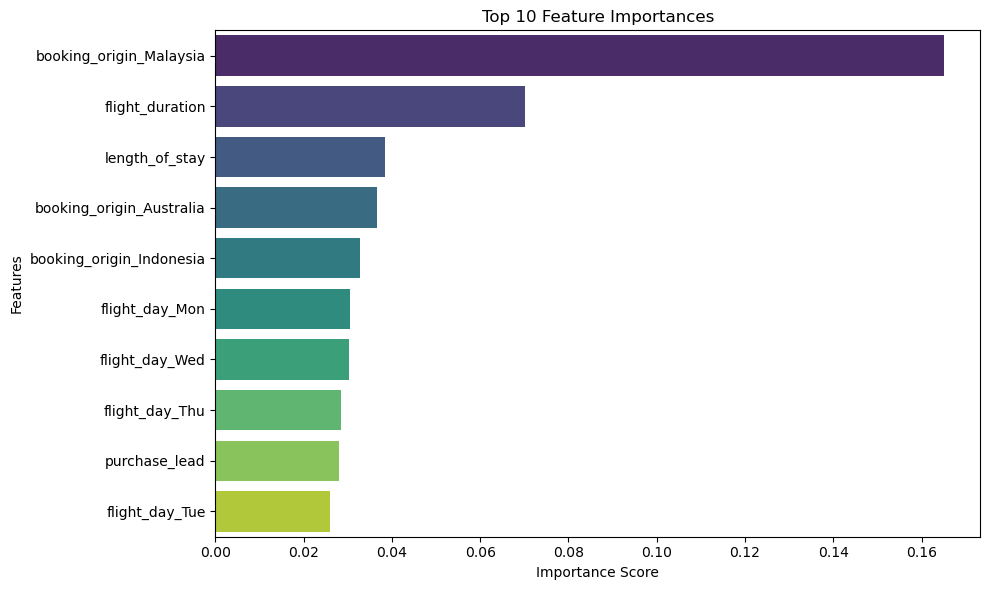

In [9]:

# 11. Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importances.head(10), x='importance', y='feature', palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

/var/folders/mb/6p3wtb813bg2nkf0321y44k80000gn/T/ipykernel_33921/2028445110.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='booking_complete', data=df, palette='Set2')


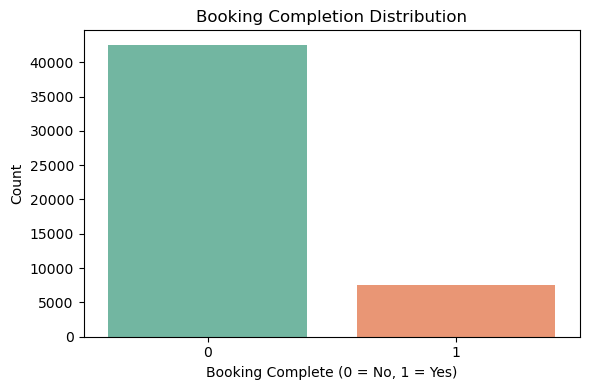

In [10]:

plt.figure(figsize=(6,4))
sns.countplot(x='booking_complete', data=df, palette='Set2')
plt.title('Booking Completion Distribution')
plt.xlabel('Booking Complete (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('booking_distribution.png')
plt.show()


/var/folders/mb/6p3wtb813bg2nkf0321y44k80000gn/T/ipykernel_33921/1644207268.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='booking_complete', y='flight_duration', data=df, palette='Set3')


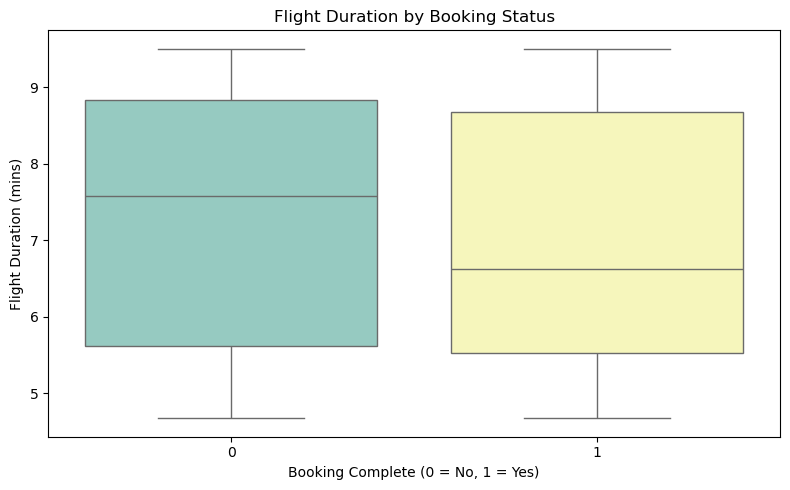

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(x='booking_complete', y='flight_duration', data=df, palette='Set3')
plt.title('Flight Duration by Booking Status')
plt.xlabel('Booking Complete (0 = No, 1 = Yes)')
plt.ylabel('Flight Duration (mins)')
plt.tight_layout()
plt.savefig('flight_duration_vs_booking.png')
plt.show()

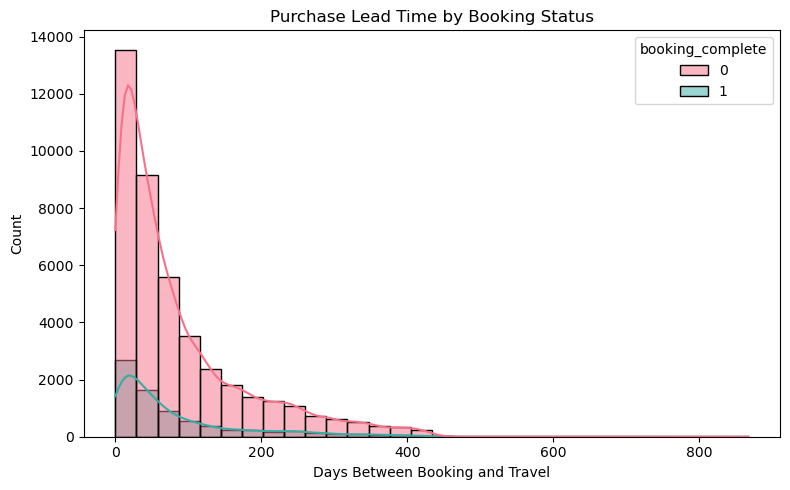

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='purchase_lead', hue='booking_complete', bins=30, kde=True, palette='husl')
plt.title('Purchase Lead Time by Booking Status')
plt.xlabel('Days Between Booking and Travel')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('purchase_lead_vs_booking.png')
plt.show()

/var/folders/mb/6p3wtb813bg2nkf0321y44k80000gn/T/ipykernel_33921/1690651083.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')


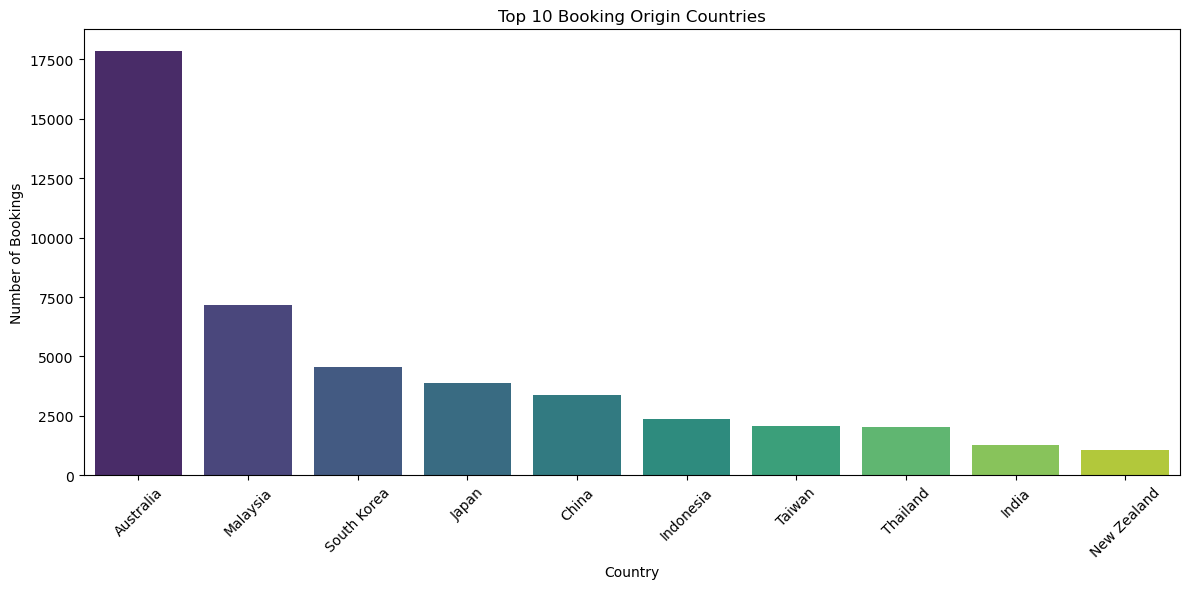

In [16]:
# Extract all booking origin columns
origin_columns = [col for col in df.columns if col.startswith('booking_origin_')]

# Create a new 'booking_origin' column by getting the country name with value 1
df['booking_origin'] = df[origin_columns].idxmax(axis=1).str.replace('booking_origin_', '')

# Count top 10 origin countries
top_countries = df['booking_origin'].value_counts().head(10)

# Plot the top 10 countries
plt.figure(figsize=(12,6))
sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')
plt.title('Top 10 Booking Origin Countries')
plt.ylabel('Number of Bookings')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/mb/6p3wtb813bg2nkf0321y44k80000gn/T/ipykernel_33921/401431103.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_country_df, x='booking_origin', y='booking_complete', estimator='mean', palette='coolwarm')


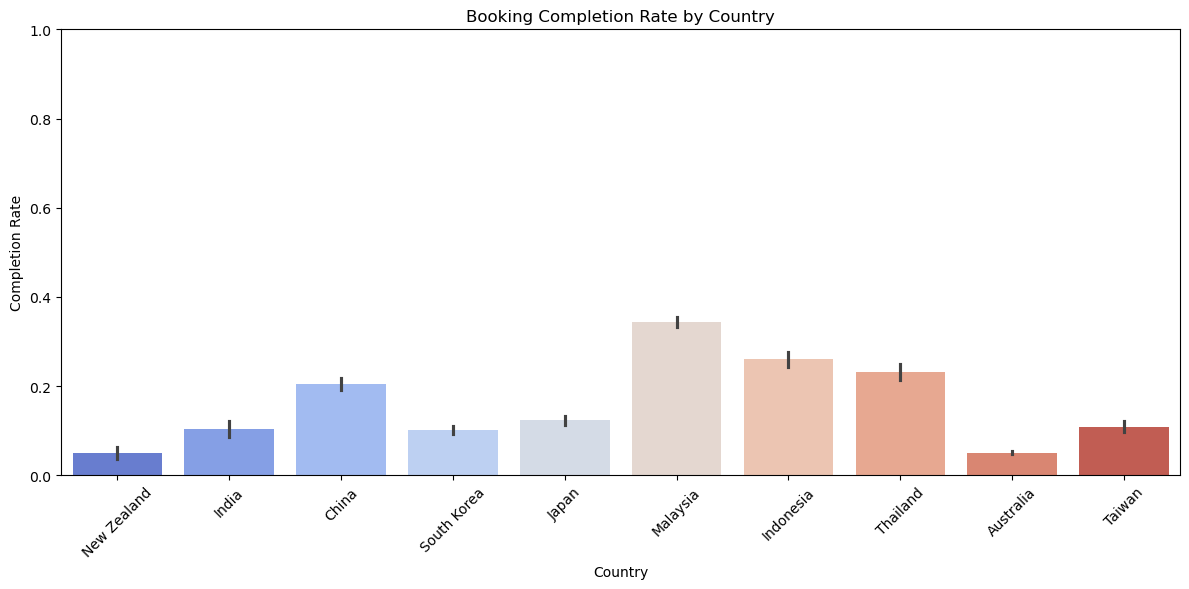

In [17]:
# Filter only top countries
top_country_df = df[df['booking_origin'].isin(top_countries.index)]

# Plot completion rate
plt.figure(figsize=(12,6))
sns.barplot(data=top_country_df, x='booking_origin', y='booking_complete', estimator='mean', palette='coolwarm')
plt.title('Booking Completion Rate by Country')
plt.ylabel('Completion Rate')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()